# 演習
RNNの層にGRUを使用して、画像の生成を行いましょう。  
GRUを使用したモデルのクラスを記述します。


## データの前処理
画像データをRNNに適した形に整えます。  

In [2]:
import torch
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

img_size = 28
n_time = 14  # 時系列の数
n_in = img_size  # 入力層のニューロン数
n_mid = 256  # 中間層のニューロン数
n_out = img_size  # 出力層のニューロン数
n_sample_in_img = img_size-n_time  # 1枚の画像中のサンプル数

fmnist_data = FashionMNIST(root="./data",
                            train=True,download=True,
                            transform=transforms.ToTensor())
dataloader = DataLoader(fmnist_data, batch_size=len(fmnist_data), shuffle=False)
dataiter = iter(dataloader)  # イテレータ
train_imgs, labels = dataiter.__next__()  # データを取り出す
train_imgs = train_imgs.reshape(-1, img_size, img_size)

n_sample = len(train_imgs) * n_sample_in_img  # サンプル数

input_data = np.zeros((n_sample, n_time, n_in))  # 入力
correct_data = np.zeros((n_sample, n_out))  # 正解
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

input_data = torch.tensor(input_data, dtype=torch.float)  # テンソルに変換
correct_data = torch.tensor(correct_data, dtype=torch.float)
dataset = torch.utils.data.TensorDataset(input_data, correct_data)  # データセットの作成

train_loader = DataLoader(dataset, batch_size=128, shuffle=True)  # DataLoaderの設定

## テスト用のデータ
今回は、訓練済みのモデルが機能することを確かめるために使用します。

In [4]:
n_disp = 10  # 生成し表示する画像の数

disp_data = FashionMNIST(root="./data",
                            train=False,download=True,
                            transform=transforms.ToTensor())
disp_loader = DataLoader(disp_data, batch_size=n_disp, shuffle=False)
dataiter = iter(disp_loader)  # イテレータ
disp_imgs, labels = dataiter.__next__()  # データを取り出す
disp_imgs = disp_imgs.reshape(-1, img_size, img_size)

## 画像生成用の関数
以下の関数は、オリジナルの画像`disp_imgs`と、この画像の上半分をもとに下半分を生成した`gen_imgs`を並べて表示します。  

In [6]:
def generate_images():
    # オリジナルの画像
    print("Original:")
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(disp_imgs[i], cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

    # 下半分をRNNにより生成した画像
    print("Generated:")
    gen_imgs = disp_imgs.clone()
    plt.figure(figsize=(20, 2))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
            x = x.cuda()  # GPU対応
            gen_imgs[i, j+n_time] = net(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
        plt.imshow(gen_imgs[i].detach(), cmap="Greys_r", vmin=0.0, vmax=1.0)
        ax.get_xaxis().set_visible(False)  # 軸を非表示に
        ax.get_yaxis().set_visible(False)
    plt.show()

## モデルの構築
以下のセルで、Netクラスの内部にコードを記述しGRUを使ったRNNのモデルを構築しましょう。  
GRUの実装方法は、以下の公式ドキュメントが詳しいです。  
https://pytorch.org/docs/stable/nn.html#gru

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # ------- 以下にコードを書く -------
    def __init__(self):
      super().__init__()
      self.rnn=nn.GRU(
          input_size=n_in,
          hidden_size=n_mid,
          batch_first=True
      )
      self.fc=nn.Linear(n_mid,n_out)

    def forward(self,x):
      y_rnn,h=self.rnn(x,None)
      y=self.fc(y_rnn[:,-1,:])
      return y

net=Net()
net.cuda()#GPU対応
print(net)

    # ------- ここまで -------


Net(
  (rnn): GRU(28, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=28, bias=True)
)


## 学習
モデルを訓練します。  
学習には時間がかかりますので、編集→ノートブックの設定のハードウェアアクセラレーターでGPUを選択しましょう。

Epoch: 0 Loss_Train: 0.017308330783910246
Original:


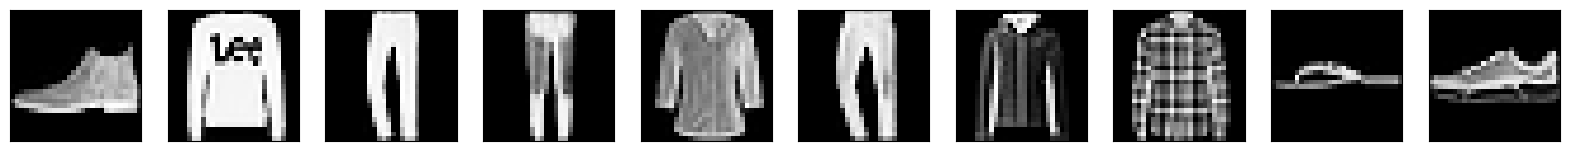

Generated:


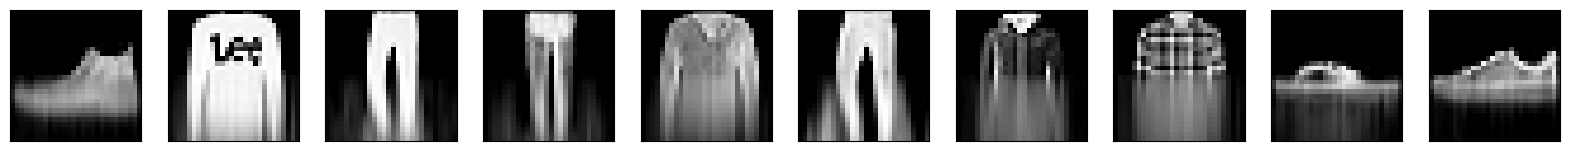

Epoch: 1 Loss_Train: 0.013553326726686332
Original:


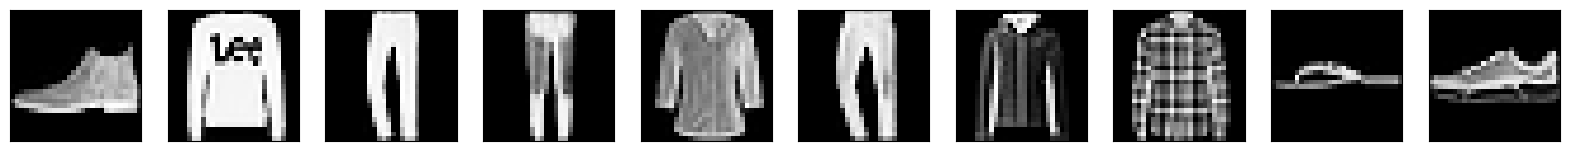

Generated:


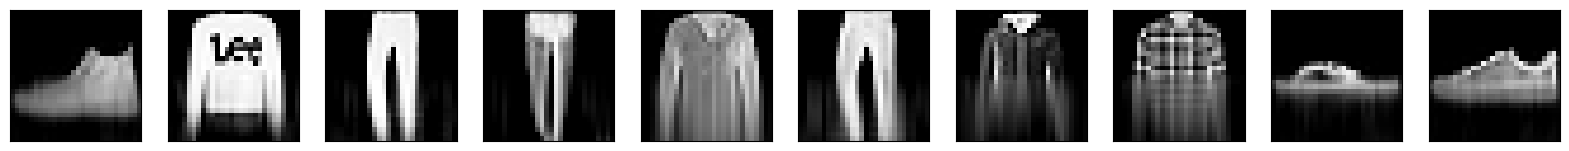

Epoch: 2 Loss_Train: 0.012592196905295533
Original:


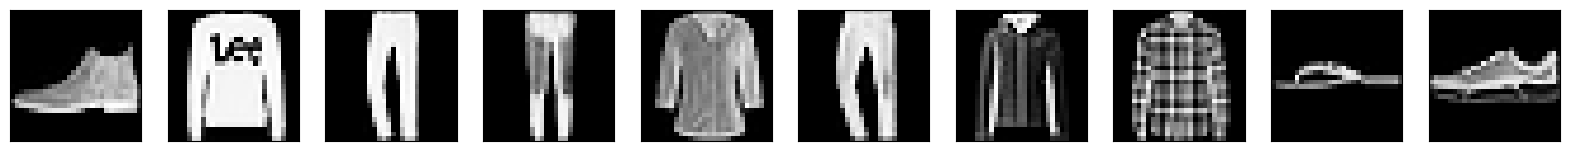

Generated:


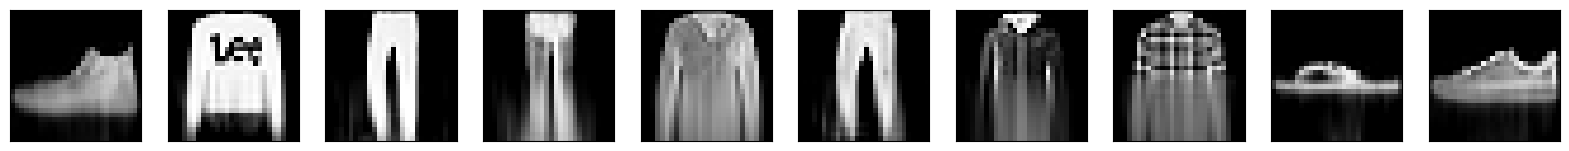

Epoch: 3 Loss_Train: 0.012107815389563566
Original:


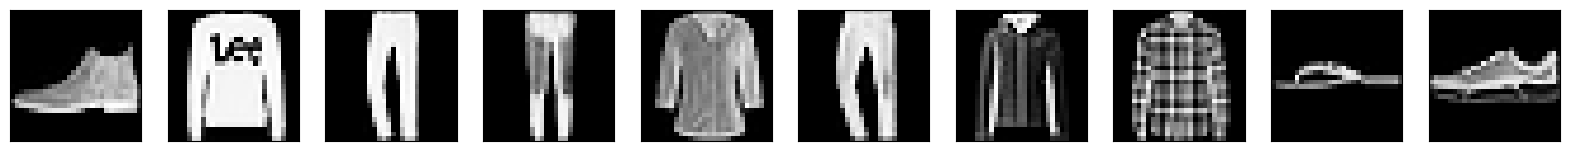

Generated:


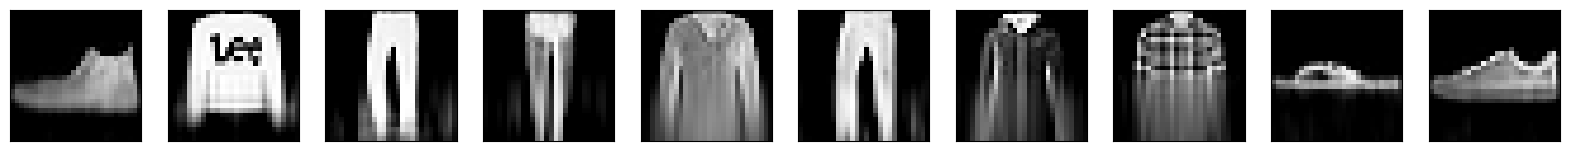

Epoch: 4 Loss_Train: 0.011785643708594308
Original:


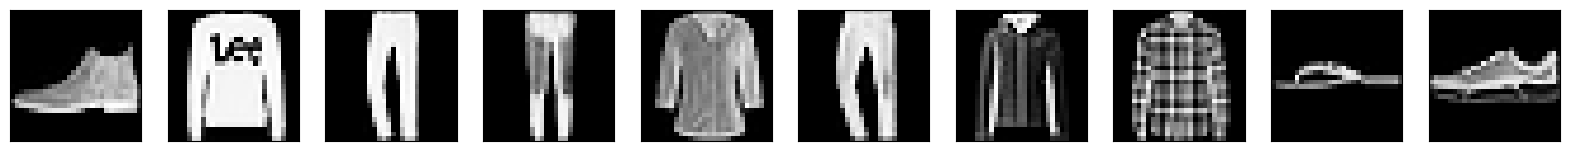

Generated:


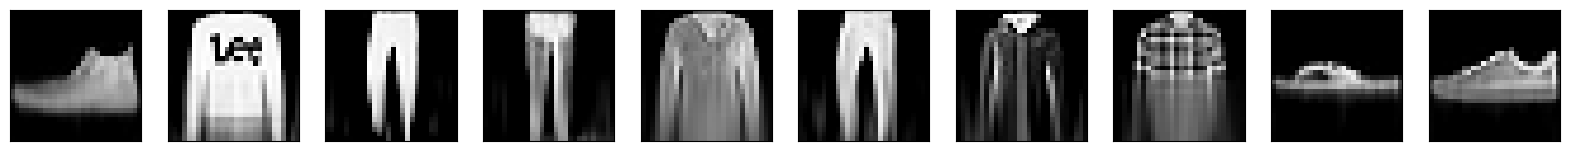

Epoch: 5 Loss_Train: 0.011533841458958822
Original:


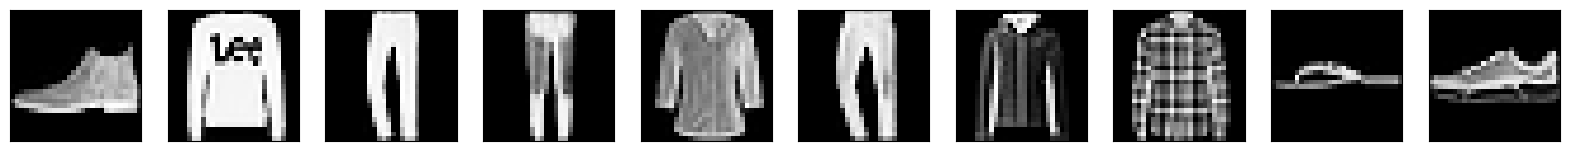

Generated:


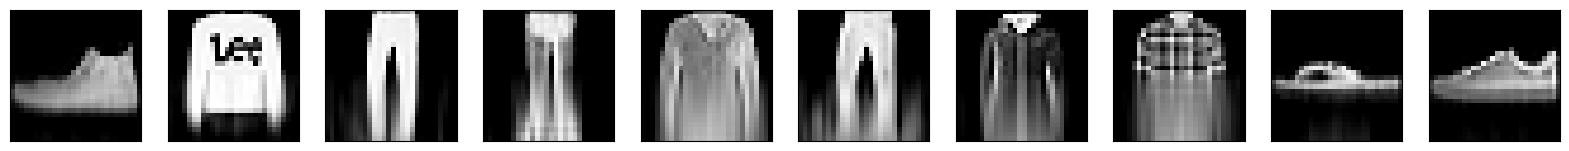

Epoch: 6 Loss_Train: 0.011328219642864665
Original:


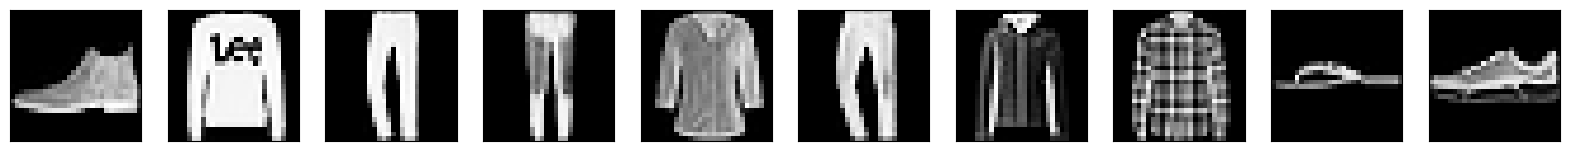

Generated:


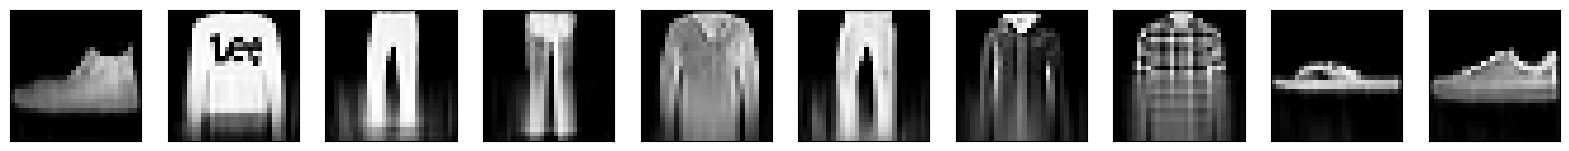

Epoch: 7 Loss_Train: 0.011147588487111717
Original:


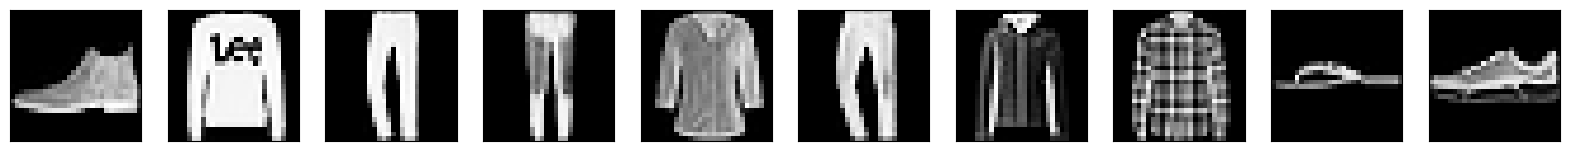

Generated:


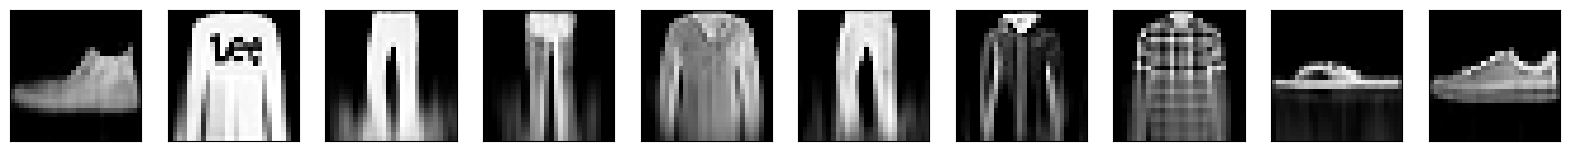

Epoch: 8 Loss_Train: 0.01099344594083396
Original:


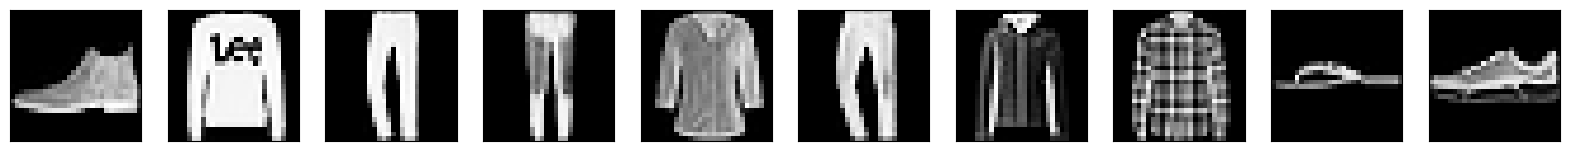

Generated:


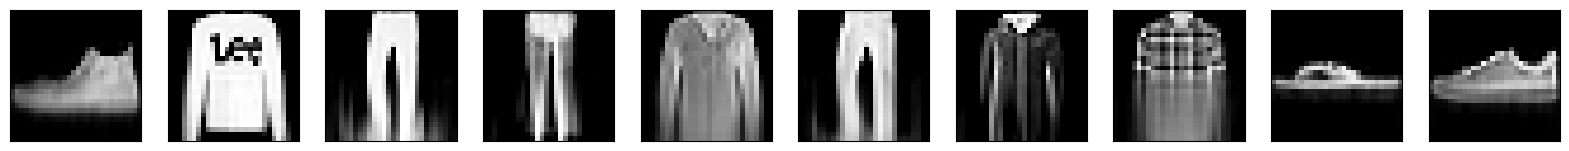

Epoch: 9 Loss_Train: 0.010859207692921488
Original:


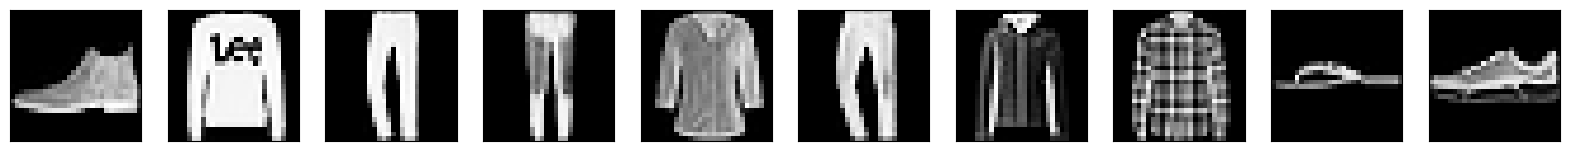

Generated:


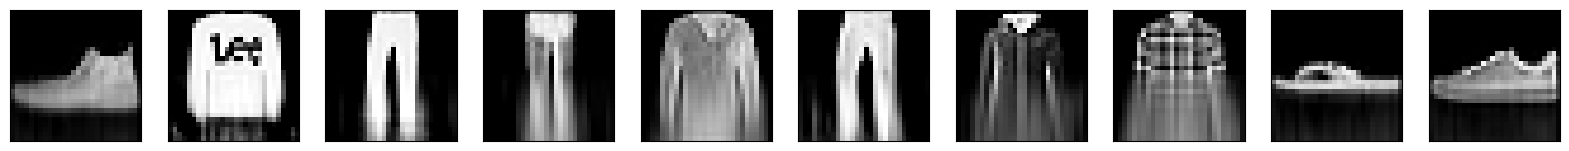

Epoch: 10 Loss_Train: 0.01075281345308322
Original:


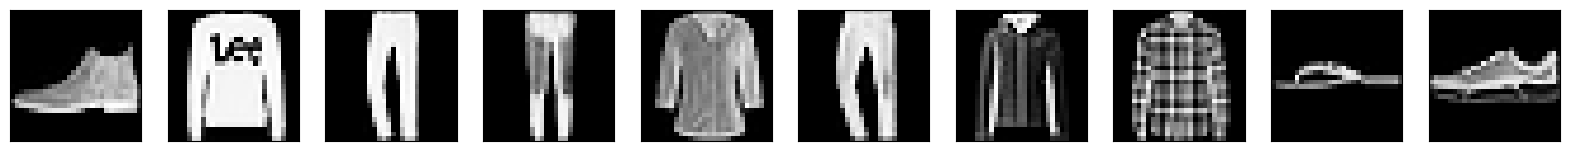

Generated:


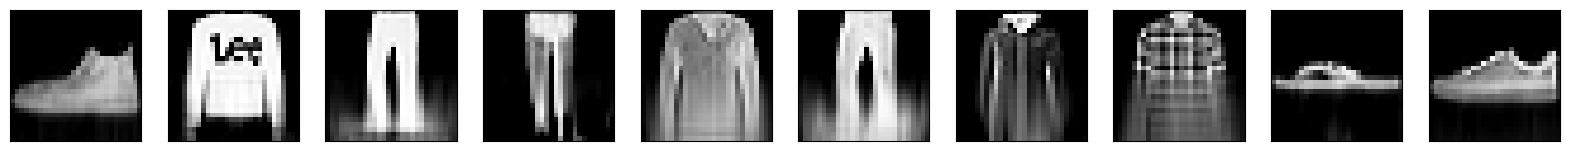

Epoch: 11 Loss_Train: 0.010641357488603844
Original:


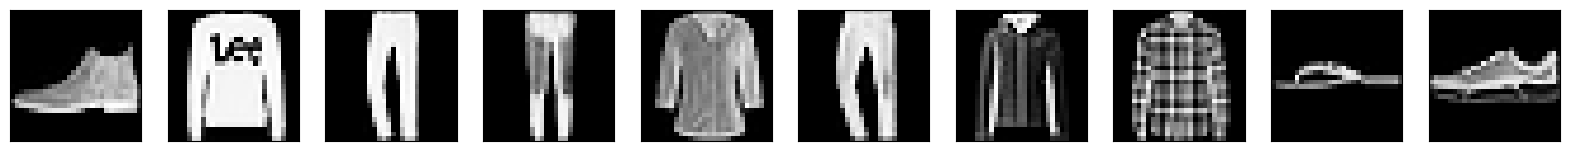

Generated:


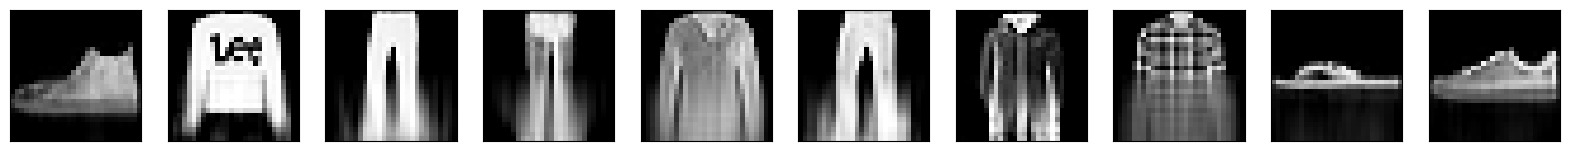

Epoch: 12 Loss_Train: 0.010541184741618265
Original:


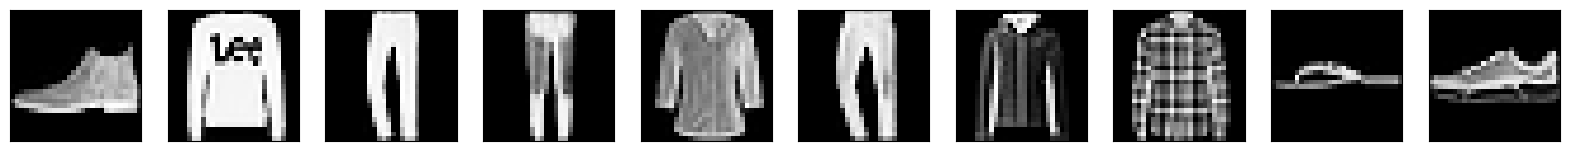

Generated:


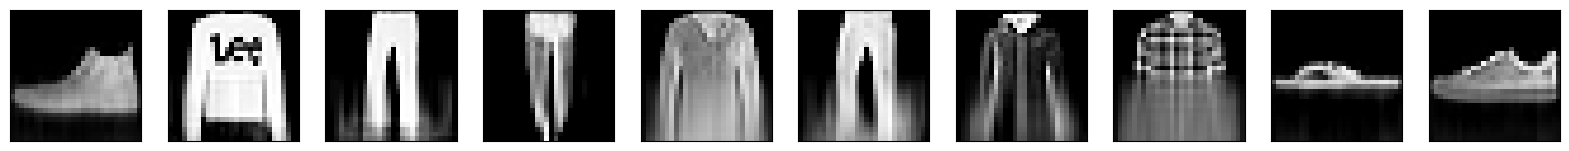

Epoch: 13 Loss_Train: 0.010457958007078381
Original:


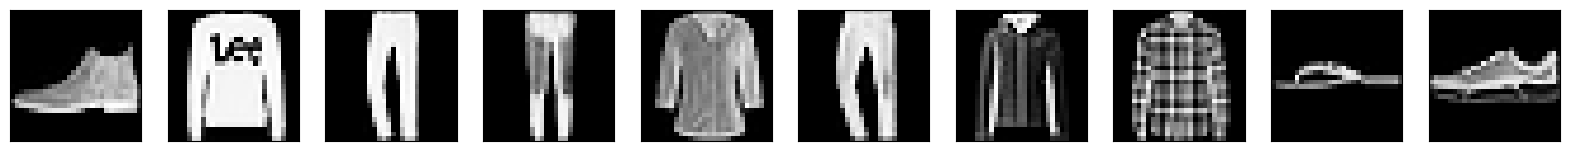

Generated:


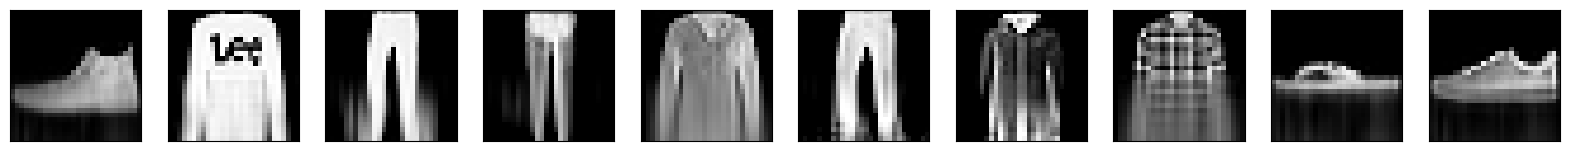

Epoch: 14 Loss_Train: 0.010381187150107548
Original:


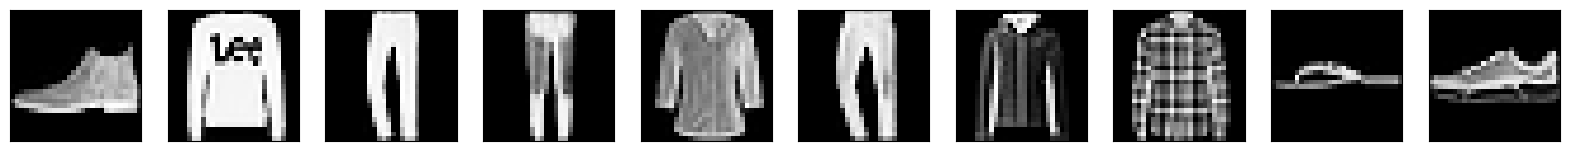

Generated:


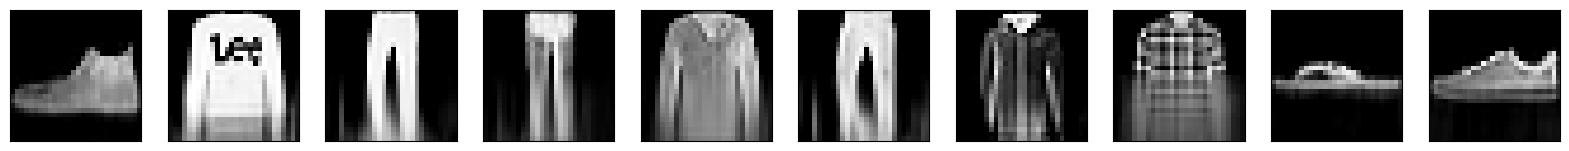

Epoch: 15 Loss_Train: 0.010316704824250678
Original:


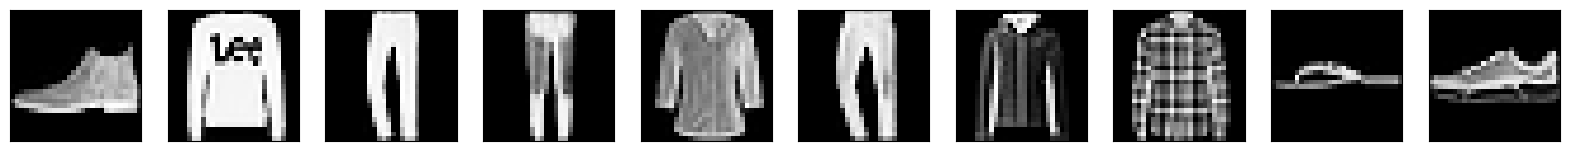

Generated:


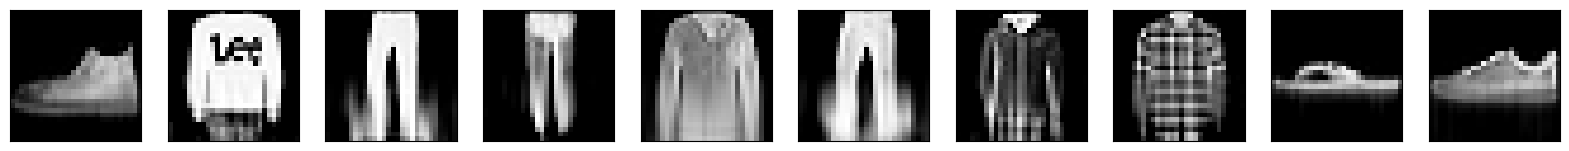

Epoch: 16 Loss_Train: 0.01024900835923284
Original:


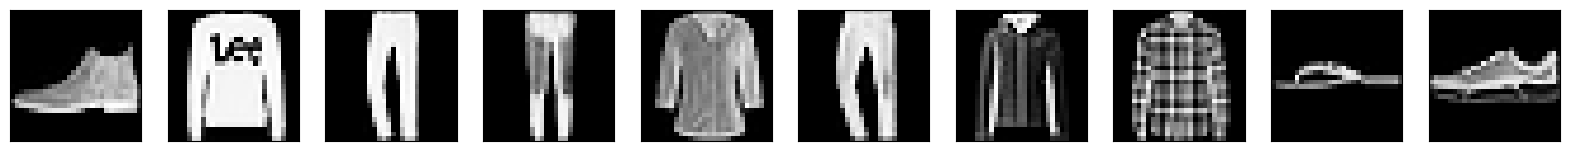

Generated:


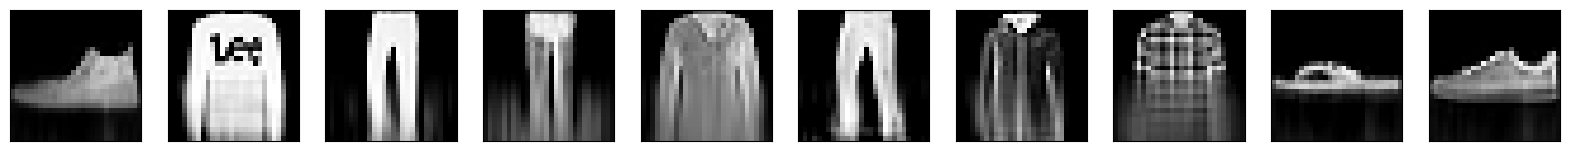

Epoch: 17 Loss_Train: 0.010183441435937227
Original:


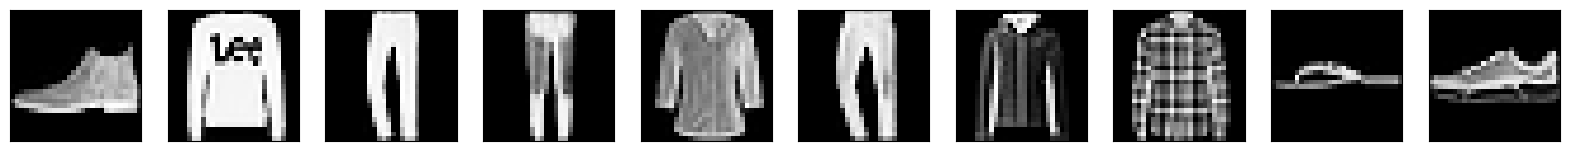

Generated:


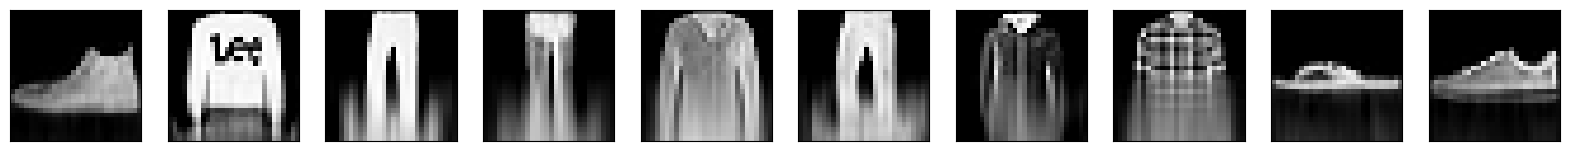

Epoch: 18 Loss_Train: 0.010128296650185529
Original:


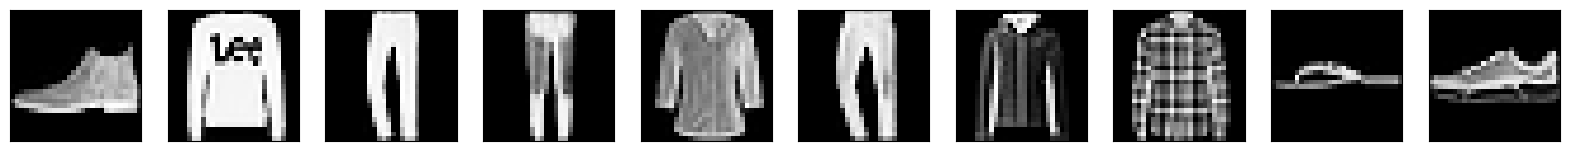

Generated:


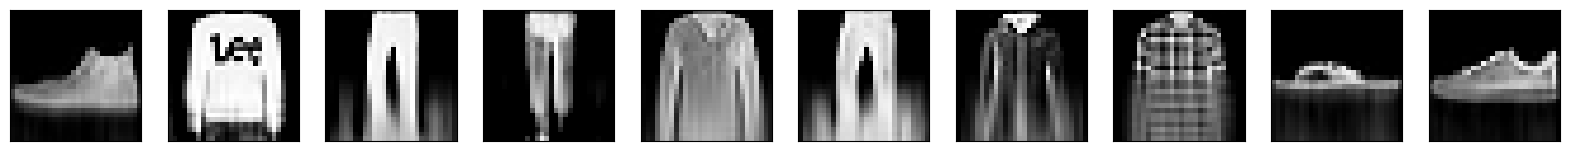

Epoch: 19 Loss_Train: 0.010091586205421511
Original:


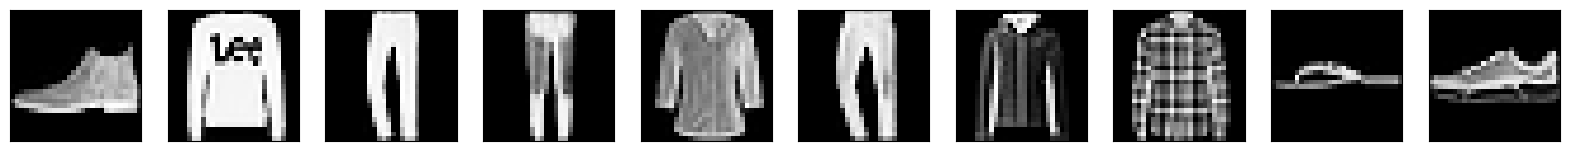

Generated:


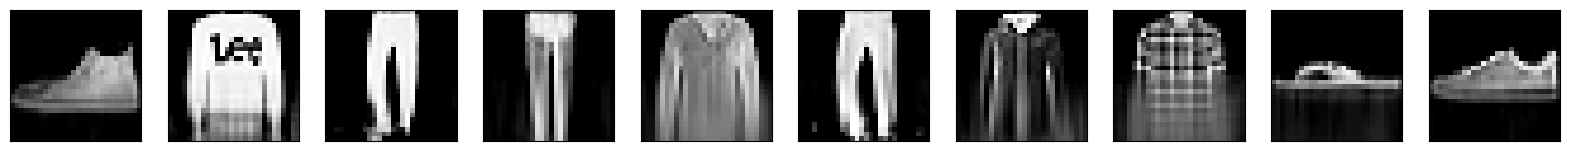

Epoch: 20 Loss_Train: 0.010034447363883588
Original:


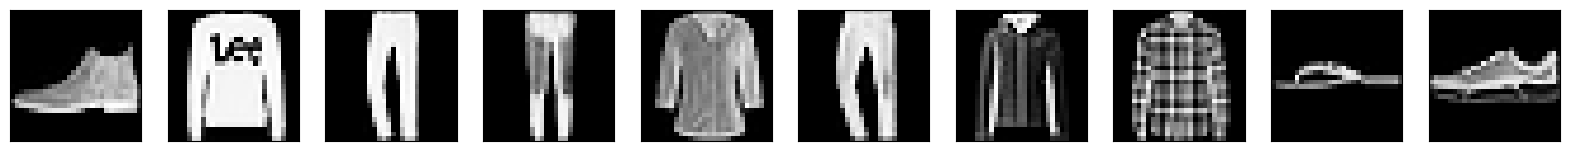

Generated:


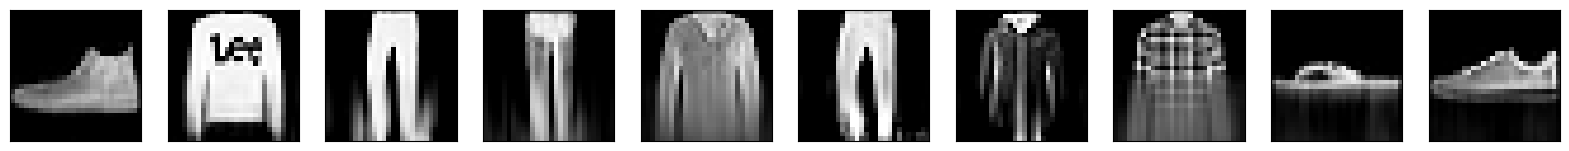

Epoch: 21 Loss_Train: 0.009990824726056157
Original:


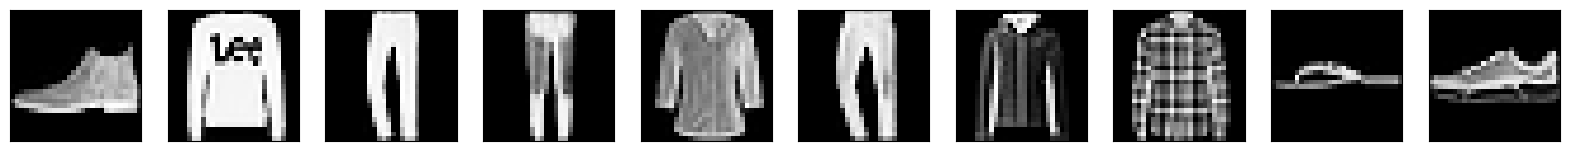

Generated:


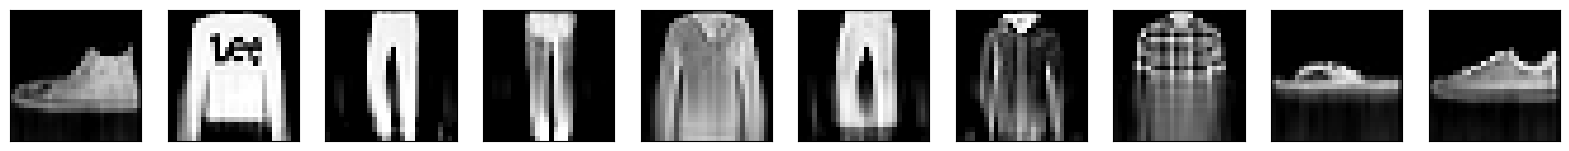

Epoch: 22 Loss_Train: 0.009982725968148769
Original:


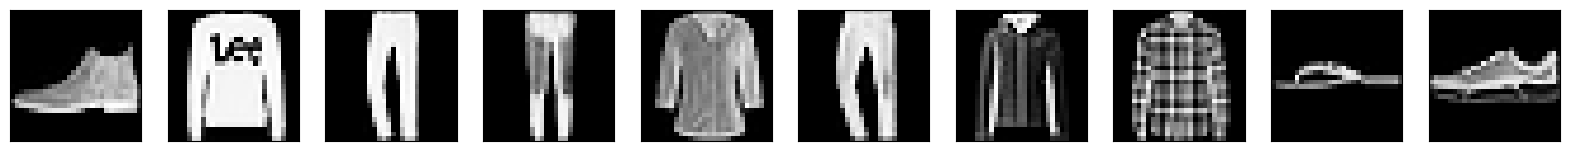

Generated:


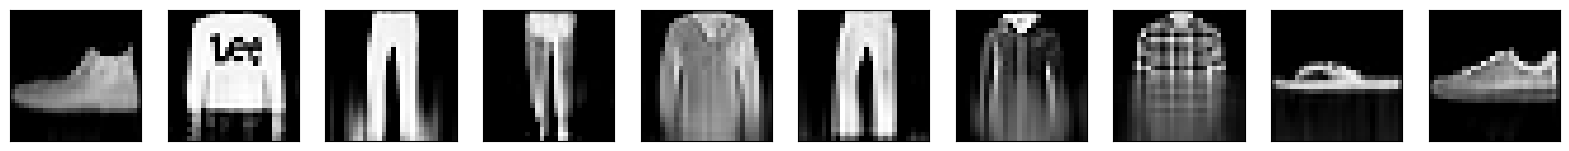

Epoch: 23 Loss_Train: 0.009905023539063362
Original:


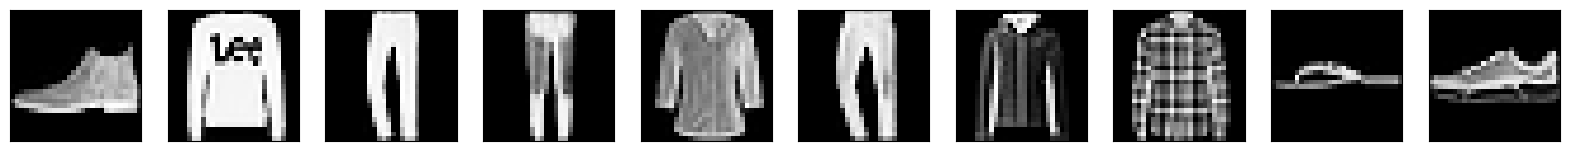

Generated:


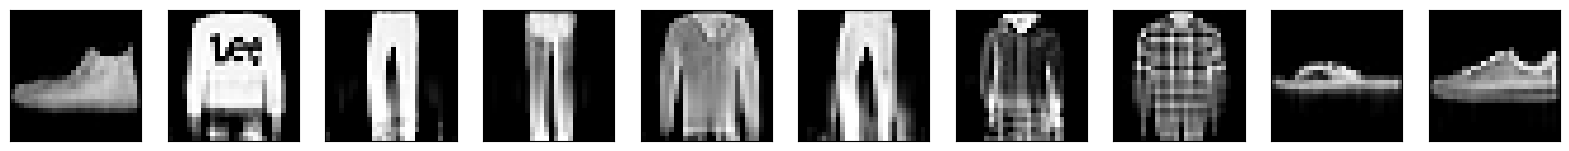

Epoch: 24 Loss_Train: 0.009868669939987588
Original:


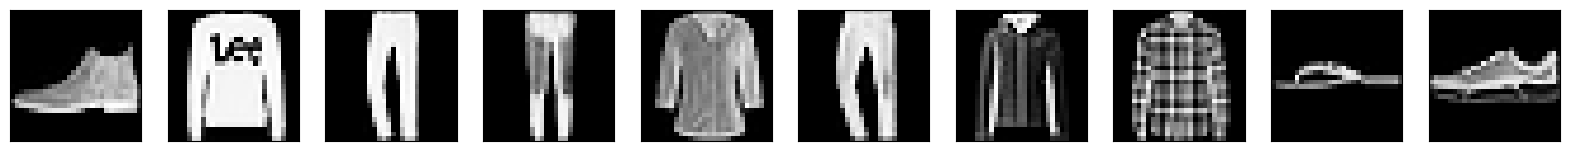

Generated:


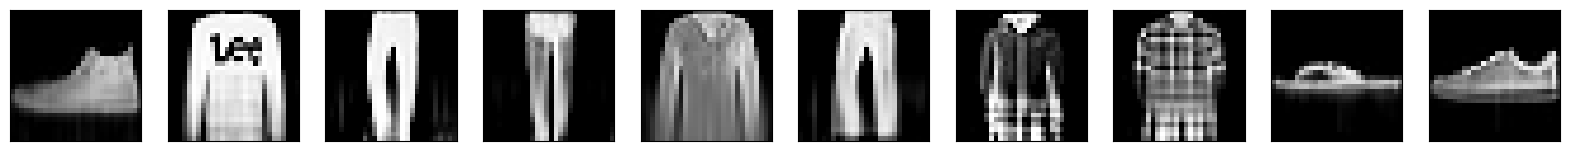

In [11]:
from torch import optim

# 交差エントロピー誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム
optimizer = optim.Adam(net.parameters())  # 学習率は0.01

# 損失のログ
record_loss_train = []

# 学習
for i in range(25):  # 25エポック学習
    net.train()  # 訓練モード
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # ミニバッチ（x, t）を取り出す
        x, t = x.cuda(), t.cuda()  # GPU対応
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train)
        generate_images()

## 誤差の推移
誤差の推移をグラフ表示します。  

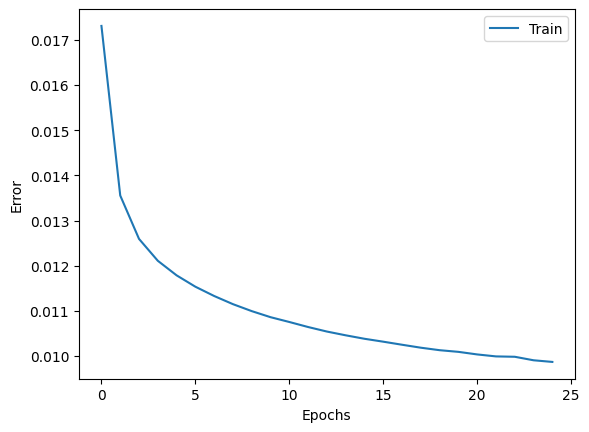

In [12]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

# 解答例
以下は、どうしても手がかりがないときのみ参考にしましょう。

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    # ------- 以下にコードを書く -------
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(  # GRU層
            input_size=n_in,  # 入力サイズ
            hidden_size=n_mid,  # ニューロン数
            batch_first=True,  # 入力を (バッチサイズ, 時系列の数, 入力の数) にする
        )
        self.fc = nn.Linear(n_mid, n_out)  # 全結合層

    def forward(self, x):
        y_rnn, h = self.rnn(x, None)  # hは次の時刻に渡される値
        y = self.fc(y_rnn[:, -1, :])  # yは最後の時刻の出力
        return y
    # ------- ここまで -------

net = Net()
net.cuda()  # GPU対応
print(net)